In [46]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

#### Function to generate a binary image from scratch
##### Input:
* img_width: width of the image
* img_height: height of the image
* num_components: number of components in the image
##### Output:
* PIL.Image

In [47]:
def create_binary_image(img_width=128, img_height=128, num_components=3):
    """
    Create a binary image with size `(img_width, img_height)` and `num_components` connected components.
    These components may overlap.
    `1` indicates the foreground, `0` indicates the background.
    """
    # Option 1: Create a binary image with random pixels
    img = Image.new('1', (img_width, img_height))

    # Define the coordinates and sizes of the connected components
    coordinates = []
    sizes = []
    for i in range(num_components):
        x = random.randint(0, img_width-1)
        y = random.randint(0, img_height-1)
        size = random.randint(5, 15)  # Vary the size of the component
        coordinates.append((x, y))
        sizes.append(size)

    # Draw the connected components on the image
    for i, coord in enumerate(coordinates):
        x, y = coord
        size = sizes[i]
        for j in range(-size, size+1):
            for k in range(-size, size+1):
                if x+j >= 0 and x+j < img_width and y+k >= 0 and y+k < img_height:
                    img.putpixel((x+j, y+k), 1)

    return img

#### Function to visualize the image

* You can comment the `set_title()` line to see the image without the title.
* You can specify the font size or family by changing the `font` variable.

In [48]:
def visualize(img, highlight_img, name='CCL.png'):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300)
    font = {
        'family': 'Arial',
        'weight': 'normal',
        'size': 13,
    }

    axs[0].tick_params(bottom=False, top=False, left=False, right=False)
    axs[0].imshow(img)
    axs[0].set_title('Original Image', fontdict=font)
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].tick_params(bottom=False, top=False, left=False, right=False)
    axs[1].imshow(highlight_img, cmap='BrBG')
    axs[1].set_title('After CCL', fontdict=font)
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    plt.savefig('results/' + name)
    plt.show()

#### Function to perform CCL
Performing CCL on an image based on the 8-neighborhood connectivity.

##### Input: np.array
##### Output: np.array

In [49]:
def find_connected_components(arr):
    """
    Find the connected components in a binary image.
    The input array `arr` is a 2D numpy array with `1` indicating the foreground and `0` indicating the background.
    The output array `out` is a 2D numpy array with the same shape as `arr`.
    Each connected component is assigned a unique label in `out`.
    """
    out = np.zeros_like(arr)
    label = 1

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            # if the pixel is part of a new connected component
            if arr[i, j] == 1 and out[i, j] == 0:
                # use a flood fill algorithm to label the connected component
                stack = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    if arr[x, y] == 1 and out[x, y] == 0:
                        out[x, y] = label
                        if x > 0:
                            stack.append((x-1, y))
                        if x < arr.shape[0]-1:
                            stack.append((x+1, y))
                        if y > 0:
                            stack.append((x, y-1))
                        if y < arr.shape[1]-1:
                            stack.append((x, y+1))
                        if x > 0 and y > 0:
                            stack.append((x-1, y-1))
                        if x > 0 and y < arr.shape[1]-1:
                            stack.append((x-1, y+1))
                        if x < arr.shape[0]-1 and y > 0:
                            stack.append((x+1, y-1))
                        if x < arr.shape[0]-1 and y < arr.shape[1]-1:
                            stack.append((x+1, y+1))
                label += 1
    return out

In [50]:
# create an example input array
arr = np.array([
    [0, 0, 1, 1],
    [1, 0, 0, 1],
    [1, 1, 0, 0],
    [0, 0, 1, 0]
])

out = find_connected_components(arr)

# print the input and output arrays to check whether the algorithm works correctly
print("Input array:")
print(arr)
print("Output array:")
print(out)

Input array:
[[0 0 1 1]
 [1 0 0 1]
 [1 1 0 0]
 [0 0 1 0]]
Output array:
[[0 0 1 1]
 [2 0 0 1]
 [2 2 0 0]
 [0 0 2 0]]


##### Testing with a binary image

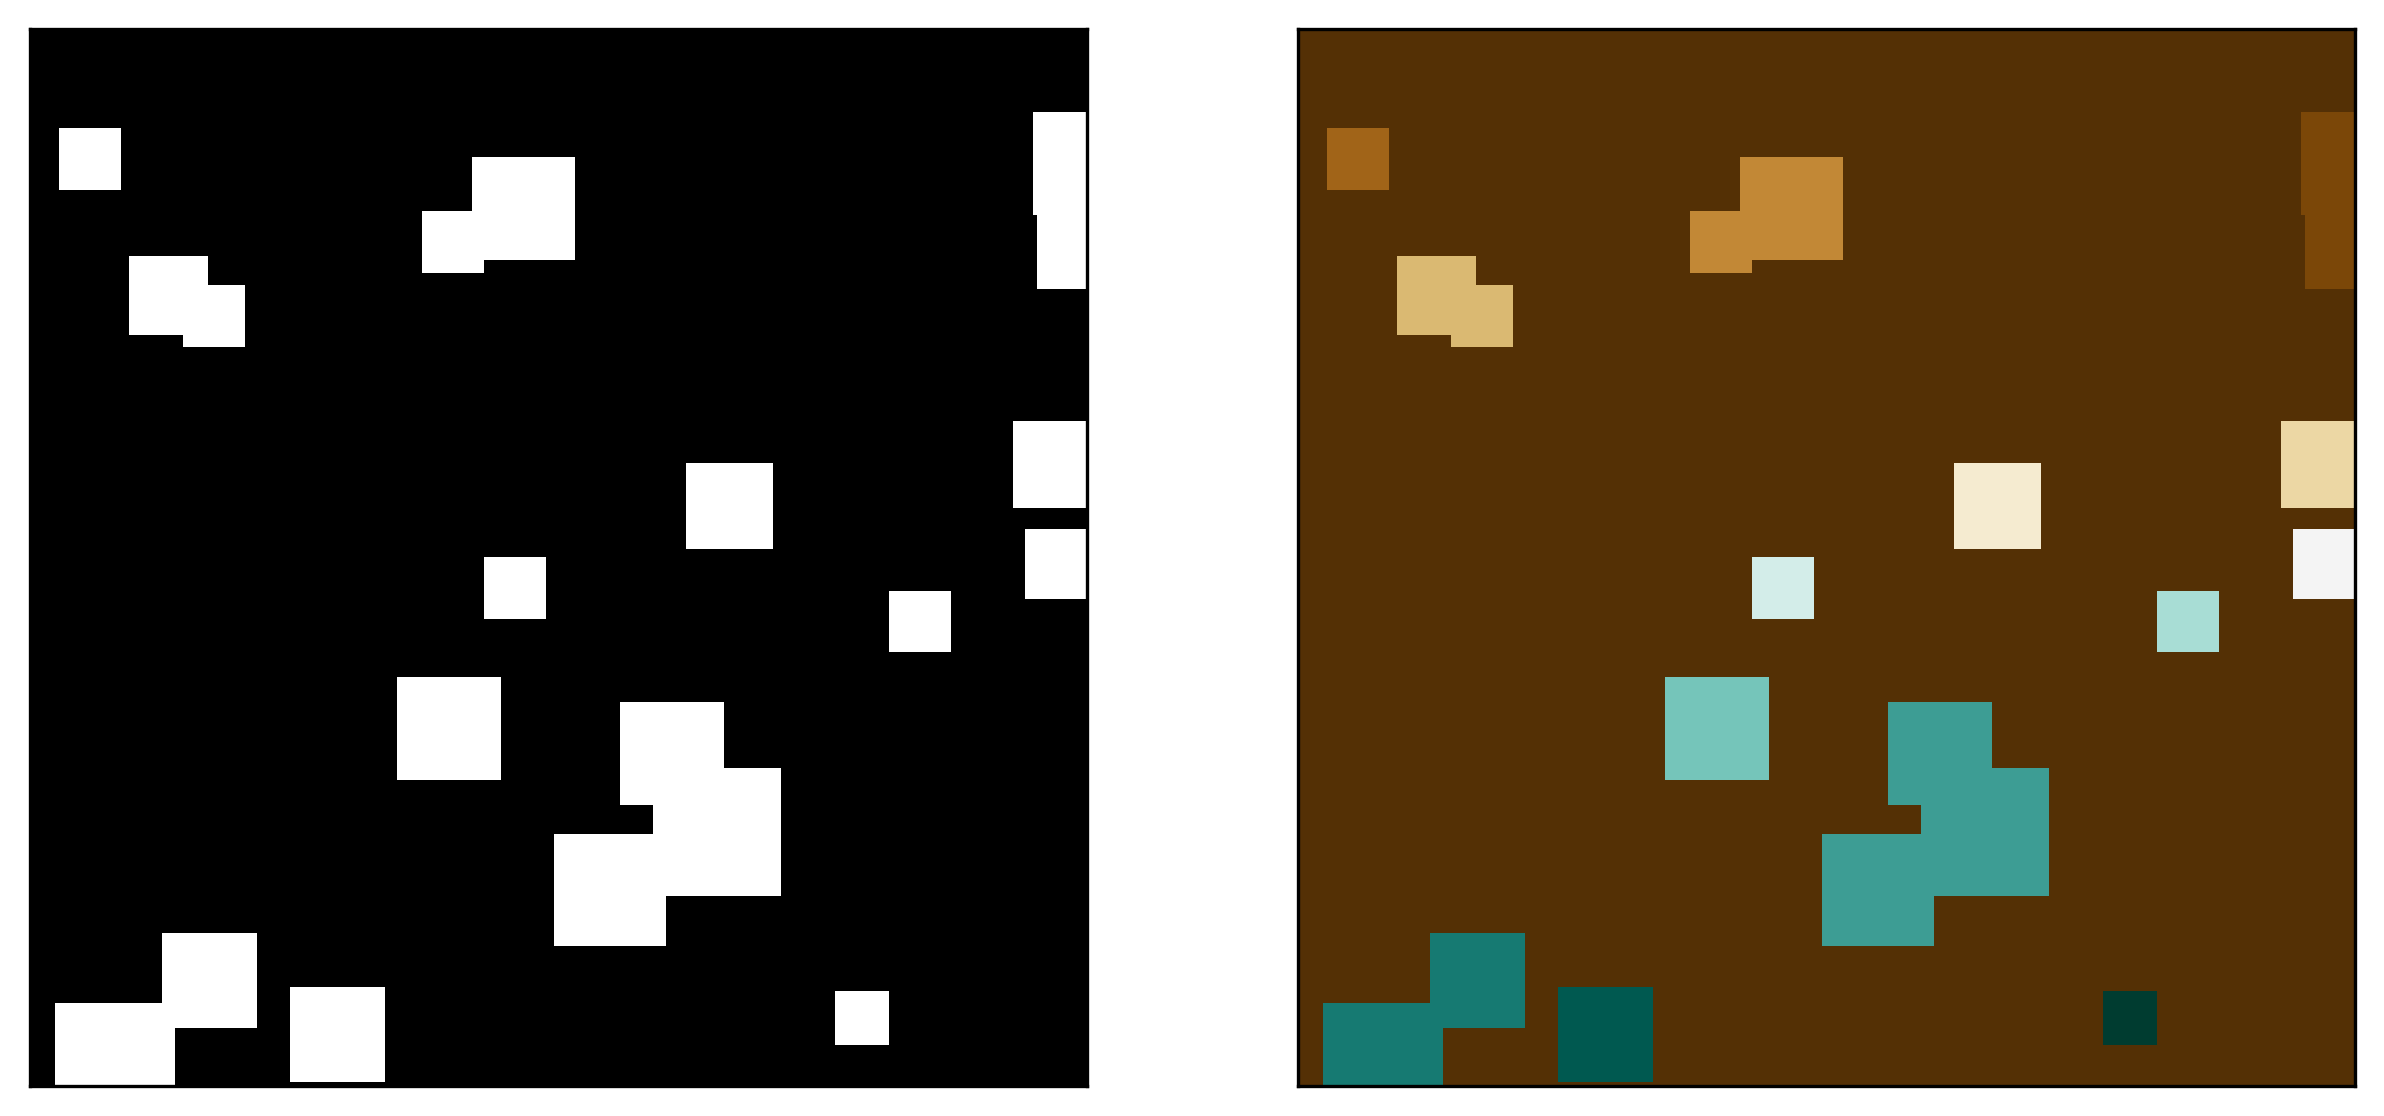

In [51]:
img = create_binary_image(256, 256, 20)
img_arr = np.array(img, dtype=np.uint8)
out = find_connected_components(img_arr)
visualize(img, out, 'binary.png')

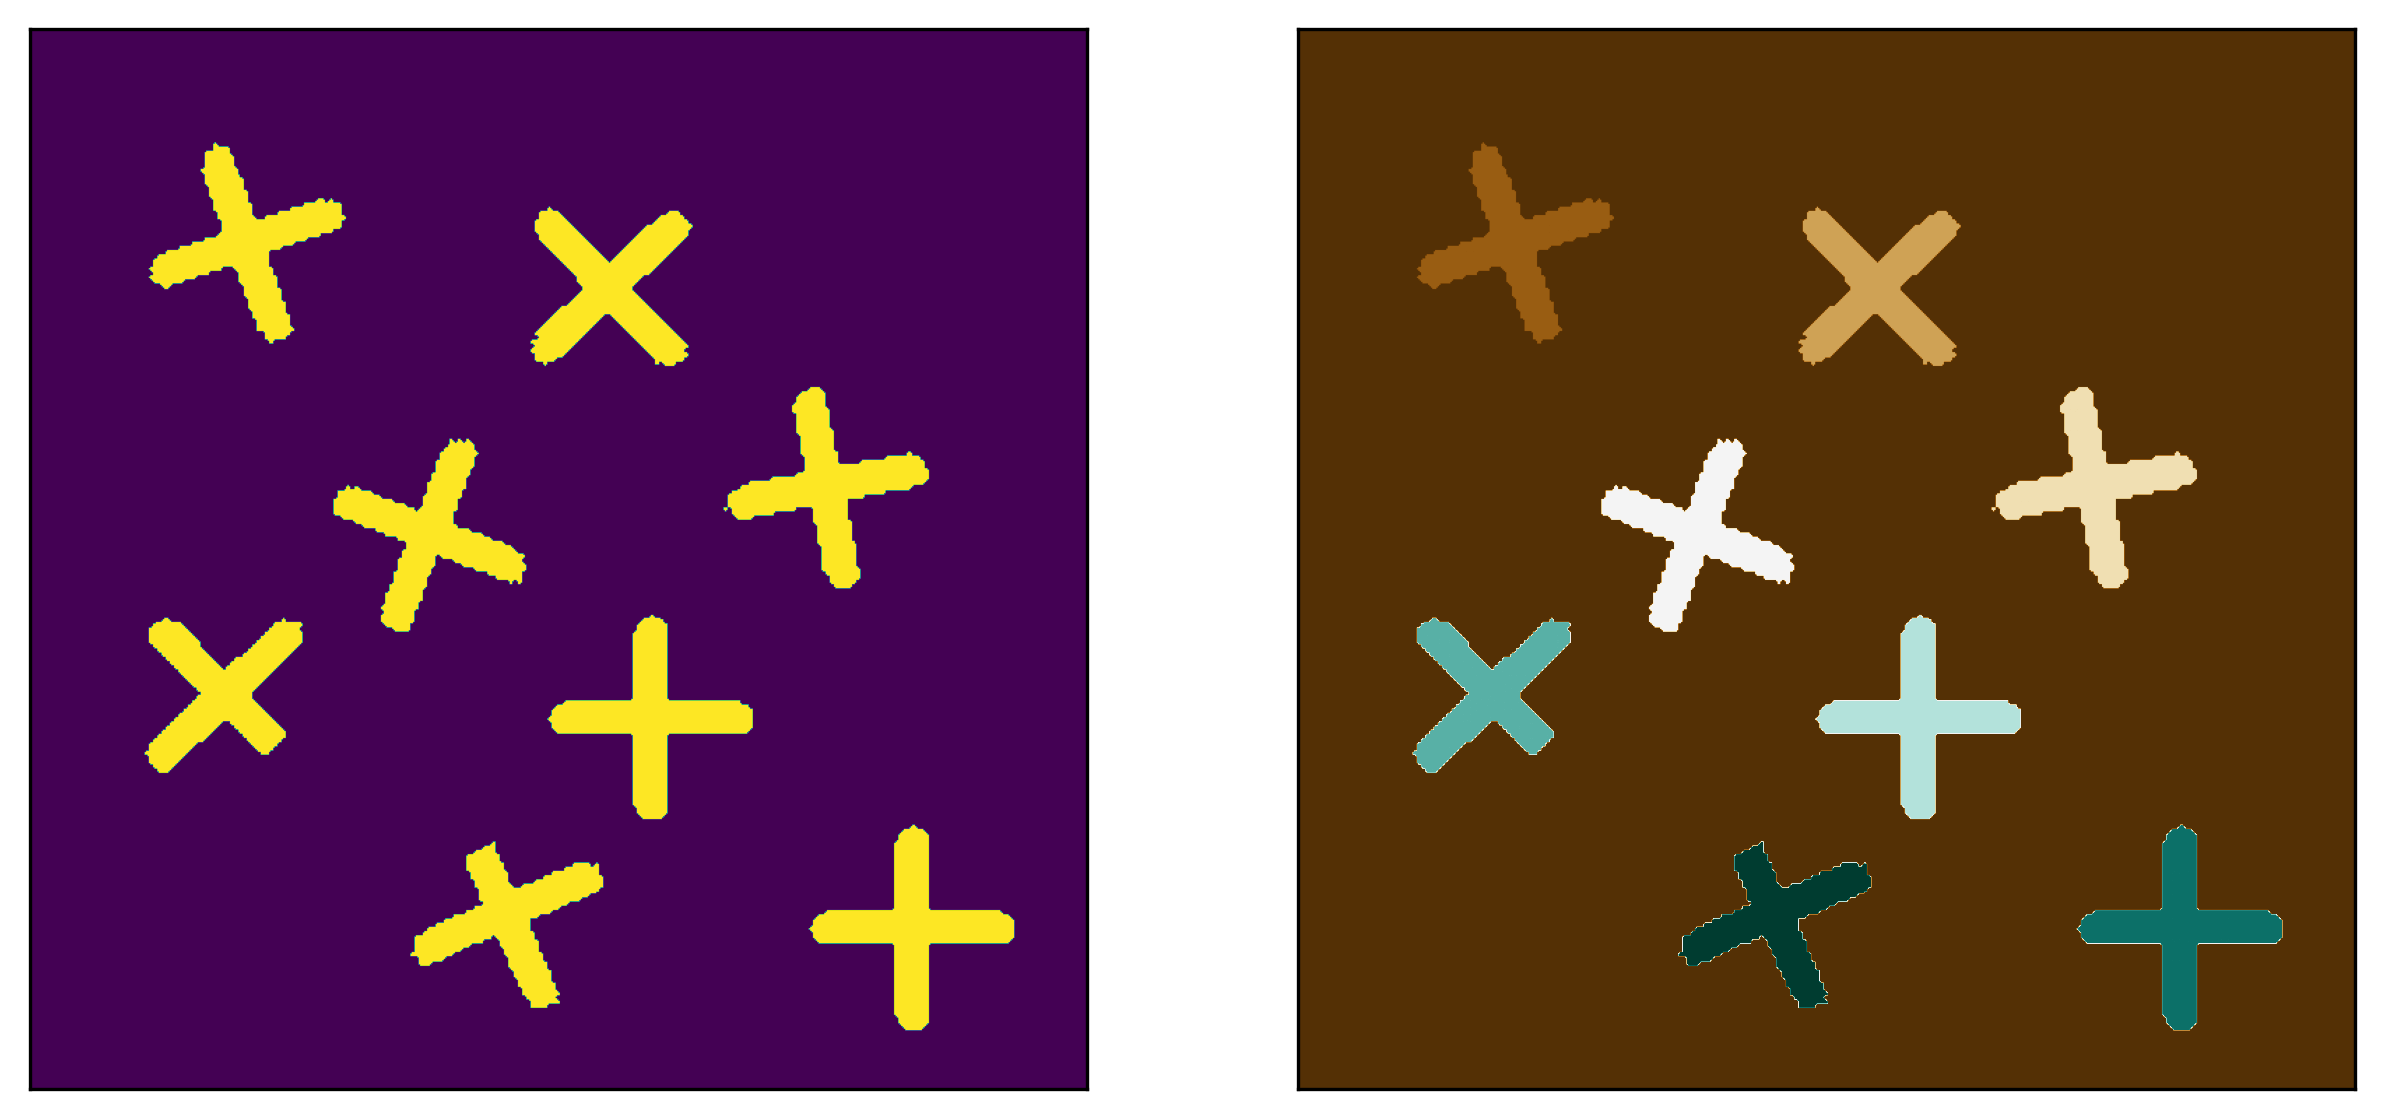

In [52]:
image = Image.open('assets/plus.png')
image = image.convert('L')
image = image.point(lambda x: 0 if x < 128 else 255, '1')
image = np.array(image, dtype=np.uint8)
out = find_connected_components(image)
visualize(image, out, 'plus.png')

##### Function to convert an RGB image to a grayscale image

In [54]:
def cvtColor(image):
    """
    Convert an image from RGB to grayscale.

    Args:
        image (numpy array): The input image in RGB format.

    Returns:
        numpy array: The grayscale image.
    """

    height, width, channels = image.shape
    gray = np.zeros((height, width), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            r, g, b = image[y, x]
            gray_value = int(0.299 * r + 0.587 * g + 0.114 * b)
            gray[y, x] = gray_value

    return gray

##### Function to convert a grayscale image to a binary image via thresholding

In [55]:
def threshold(gray, thresh, maxval, type_='binary_inv'):
    """
    Apply binary inverse Otsu thresholding on a grayscale image.

    Args:
        gray (numpy array): The input grayscale image.
        thresh (float): The threshold value.
        maxval (float): The maximum value to use for pixels above the threshold.
        type_ (int): The type of thresholding to apply.

    Returns:
        numpy array: The thresholded binary image.
    """

    height, width = gray.shape
    binary = np.zeros((height, width), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            pixel_value = gray[y, x]
            if type_ == 'binary_inv':
                if pixel_value > thresh:
                    binary[y, x] = 0
                else:
                    binary[y, x] = maxval
            else:
                if pixel_value > thresh:
                    binary[y, x] = maxval
                else:
                    binary[y, x] = 0

    return binary

##### Testing with RGB images

In [56]:
import os
def experiment():
    for filename in os.listdir('assets'):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            print(filename)
            image = Image.open('assets/' + filename).resize((500, 500), Image.Resampling.LANCZOS).convert('RGB')
            
            processed_image = cvtColor(np.array(image, dtype=np.uint8))
            processed_image = threshold(processed_image, 128, 255)
            processed_image[processed_image == 255] = 1

            out = find_connected_components(processed_image)
            visualize(image, out, filename)

fruits.jpg


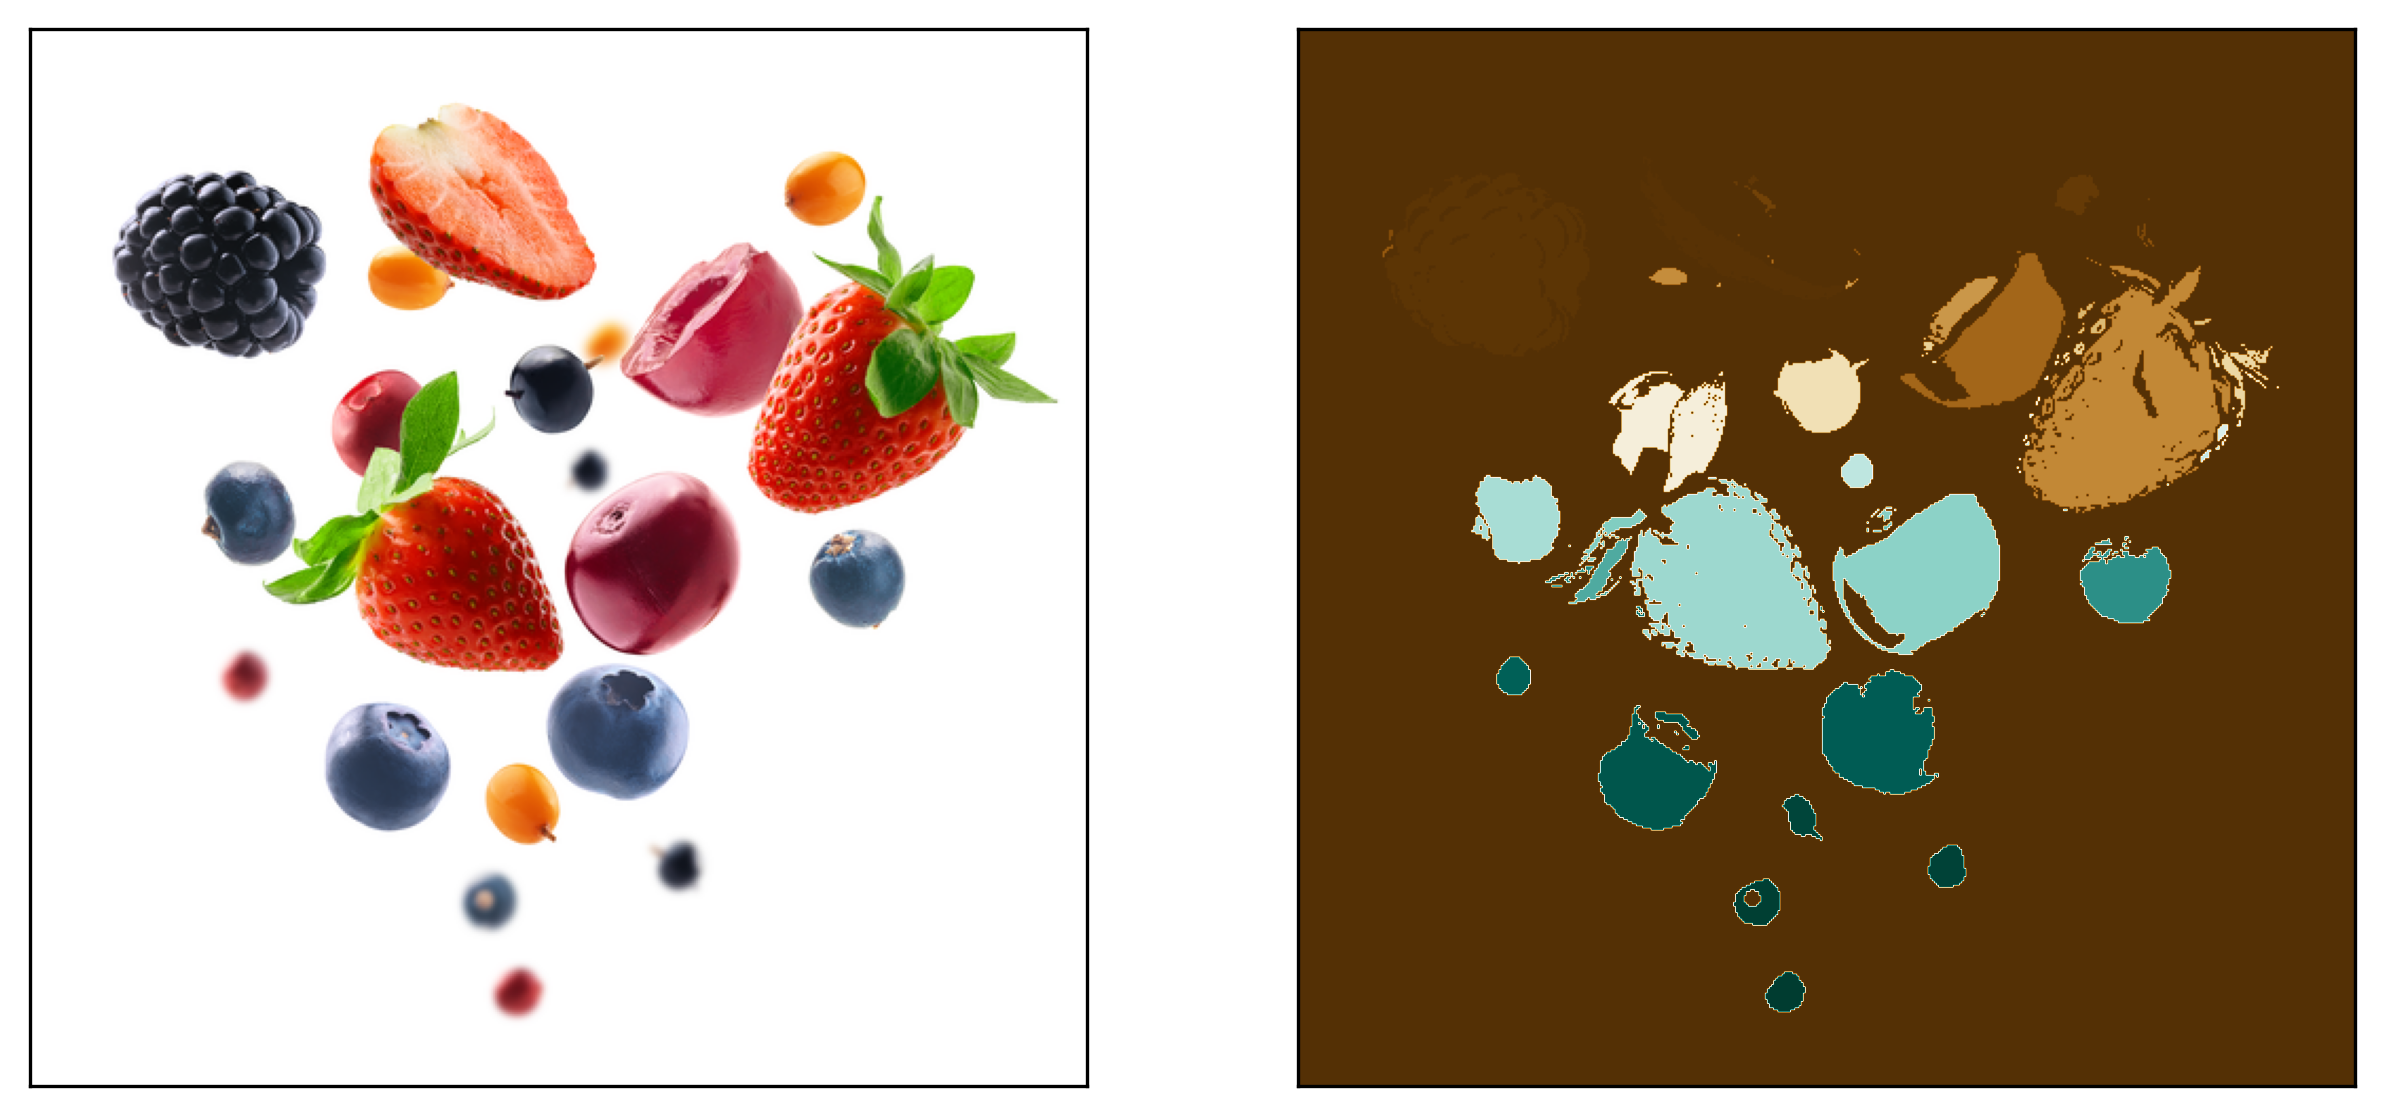

plus.png


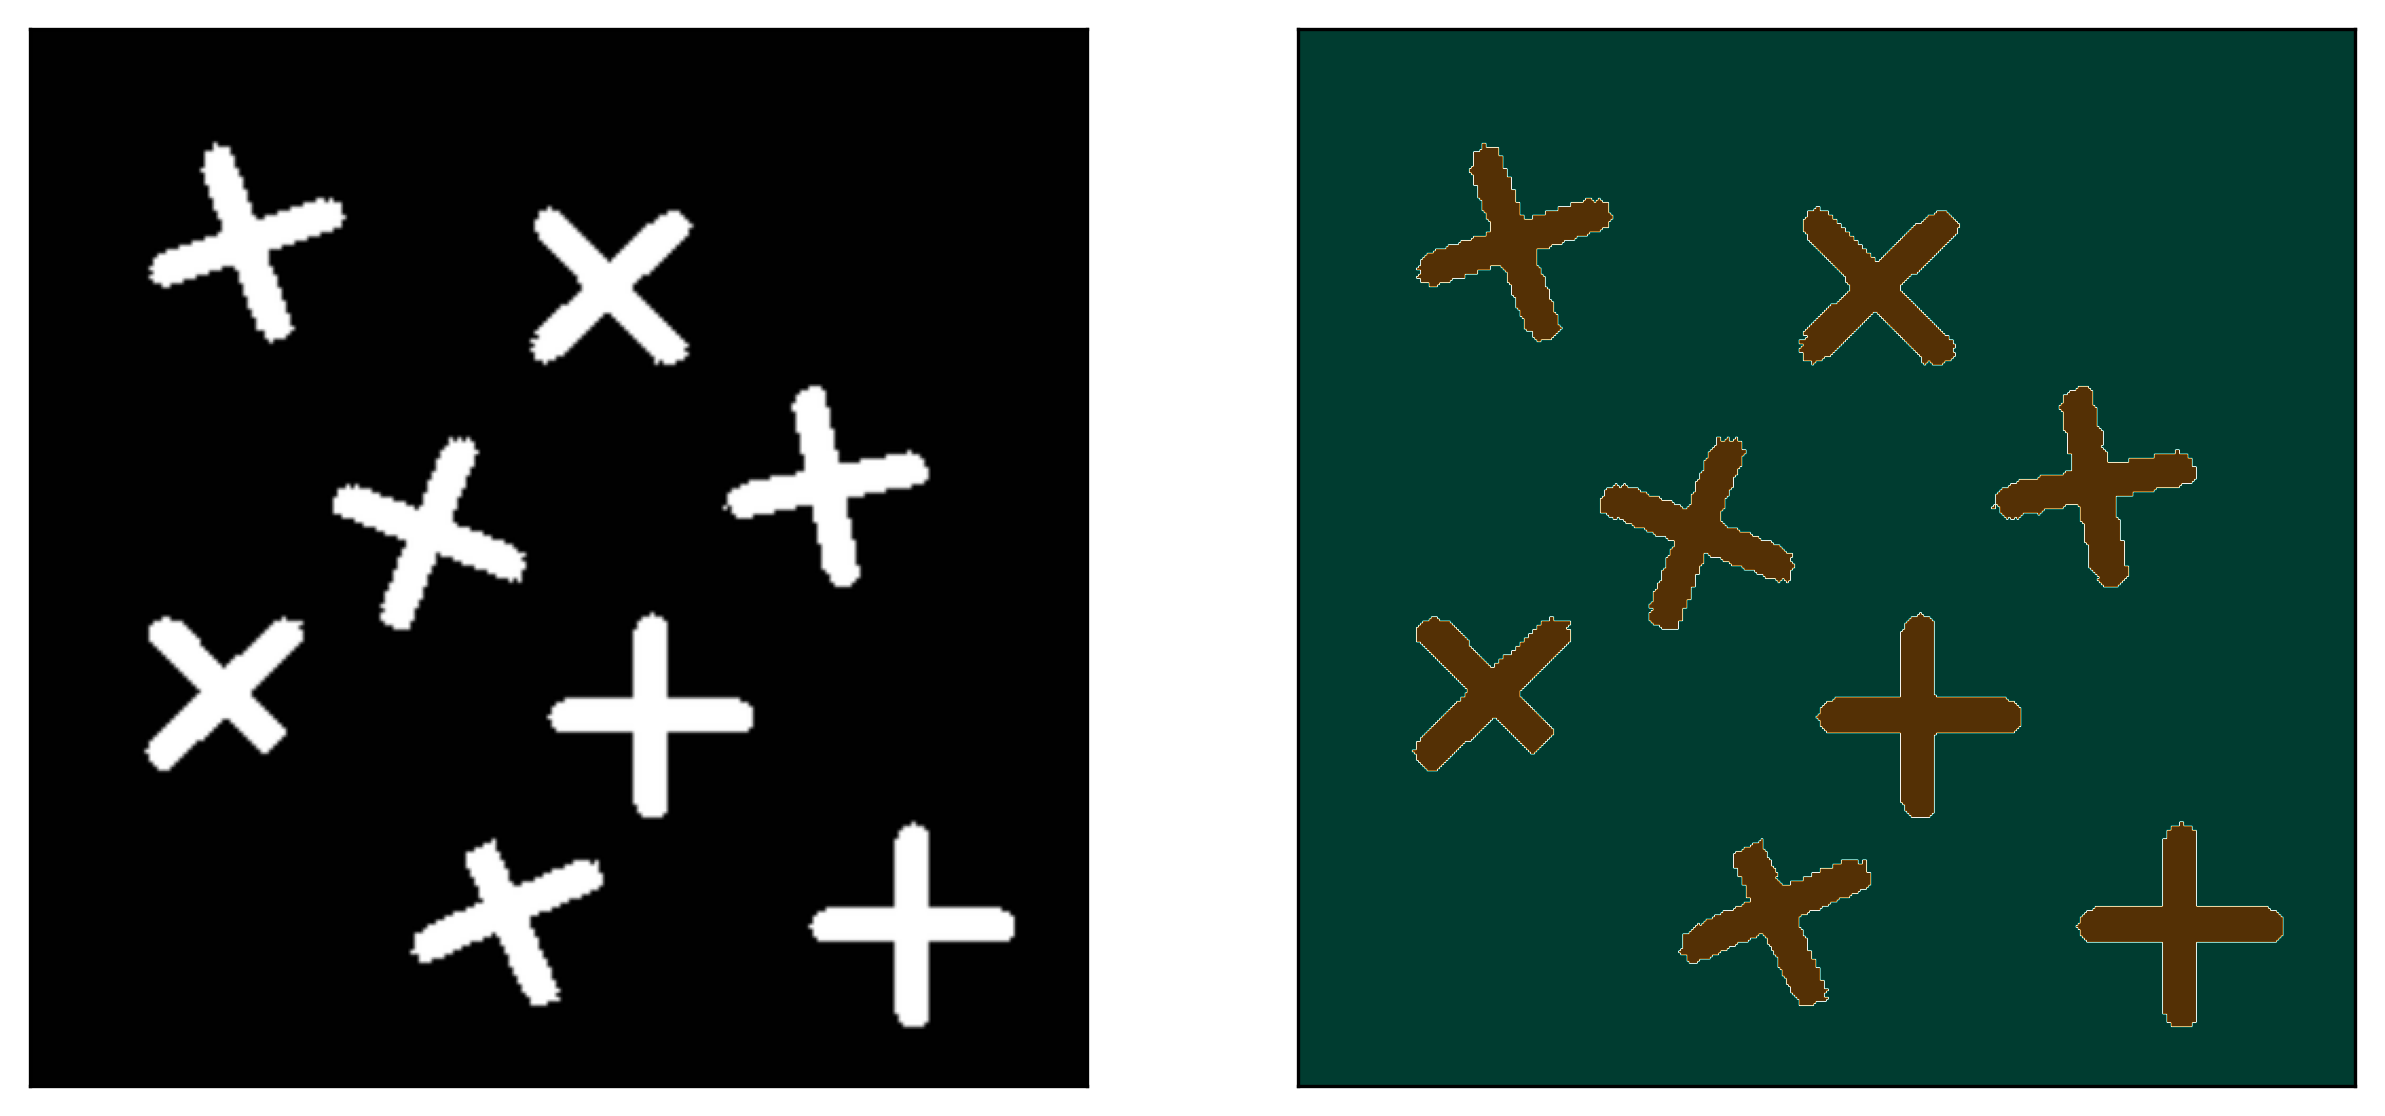

7751781.jpg


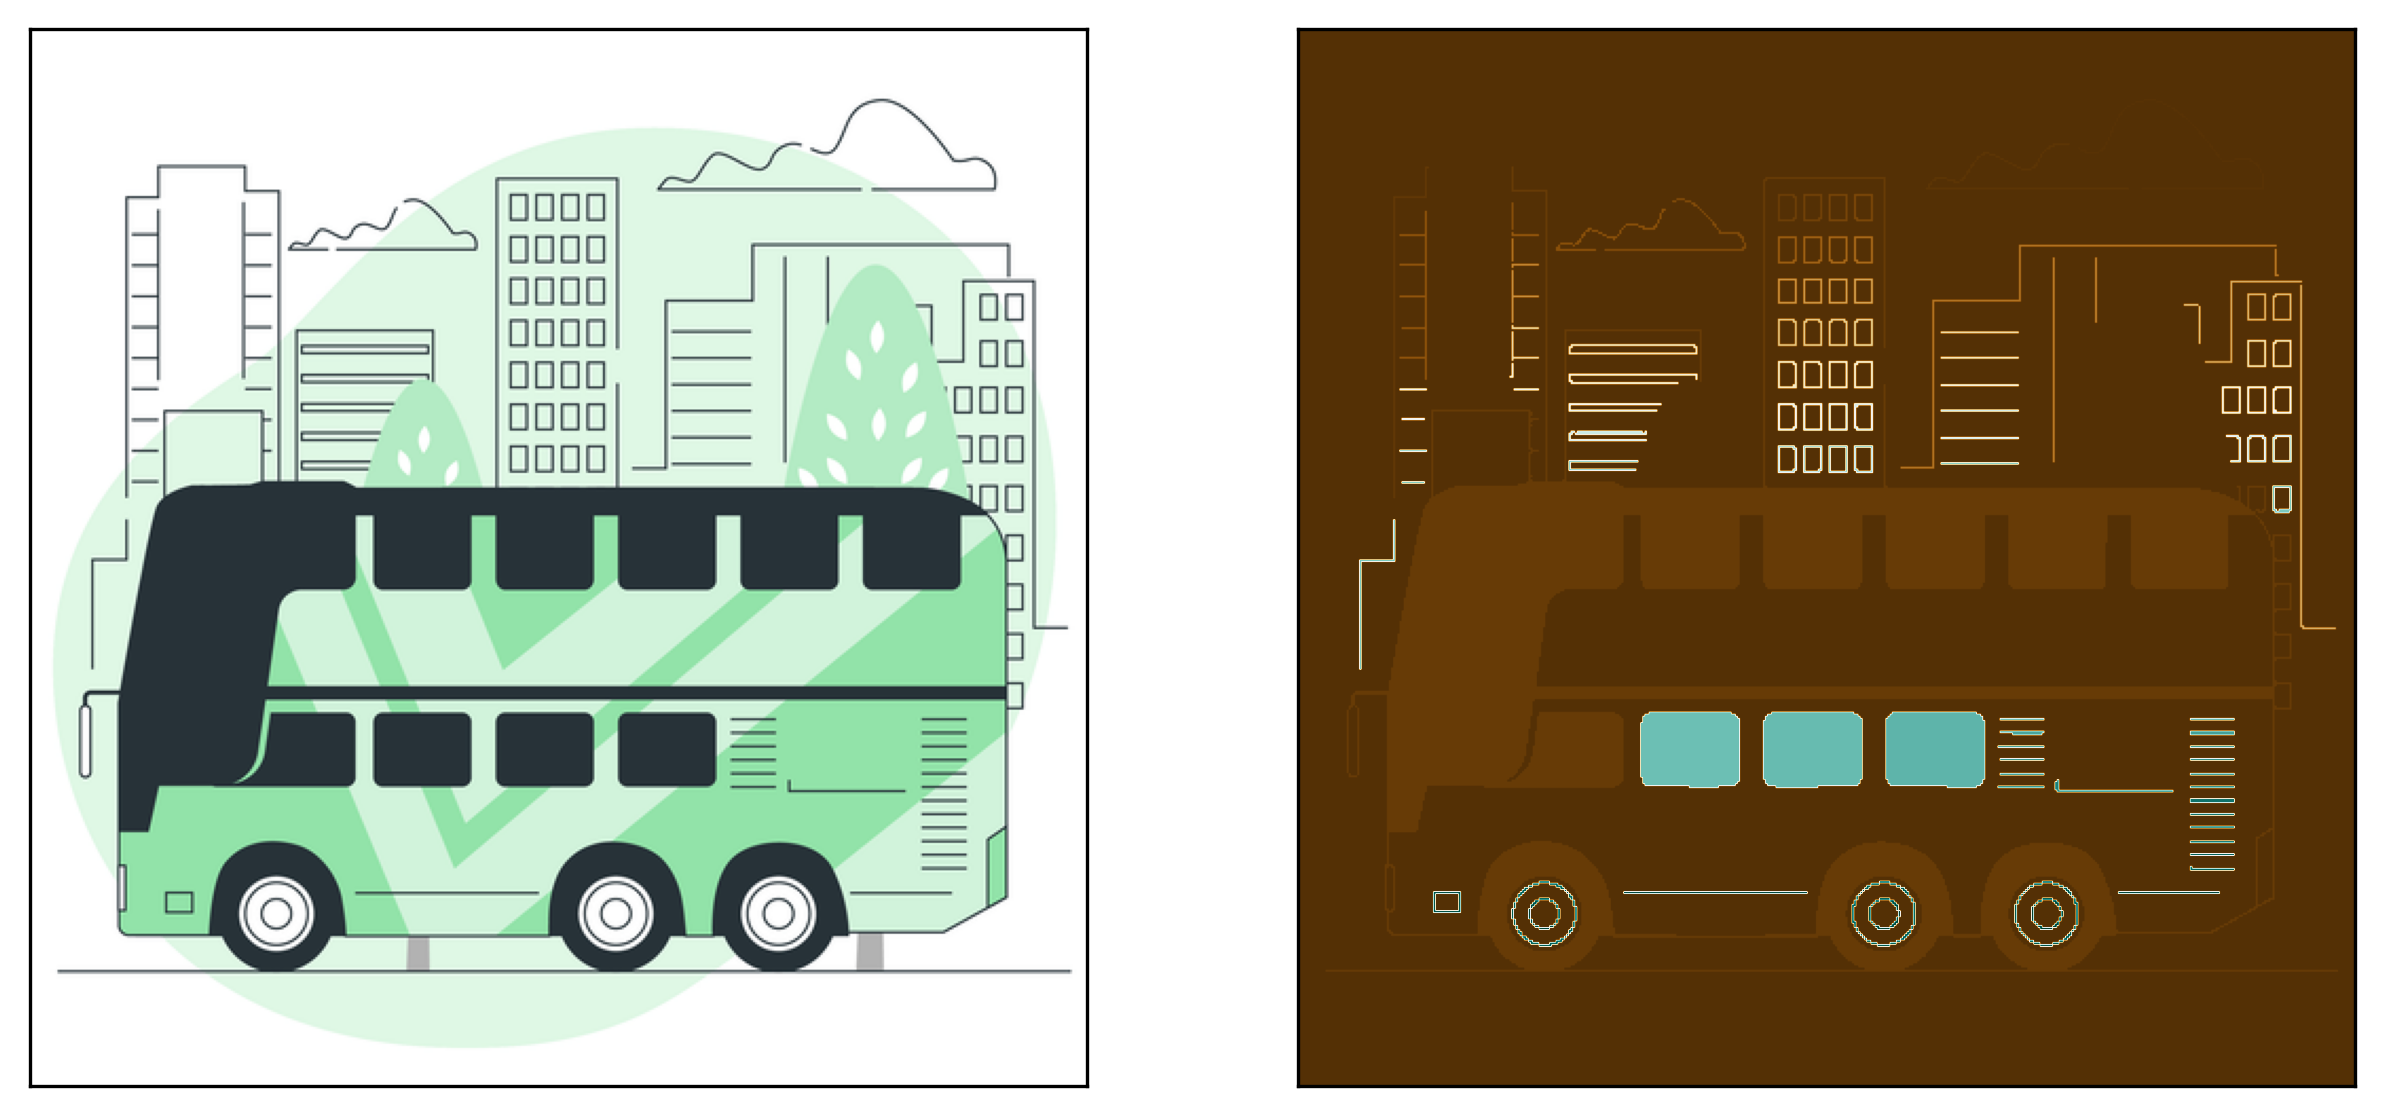

water.jpg


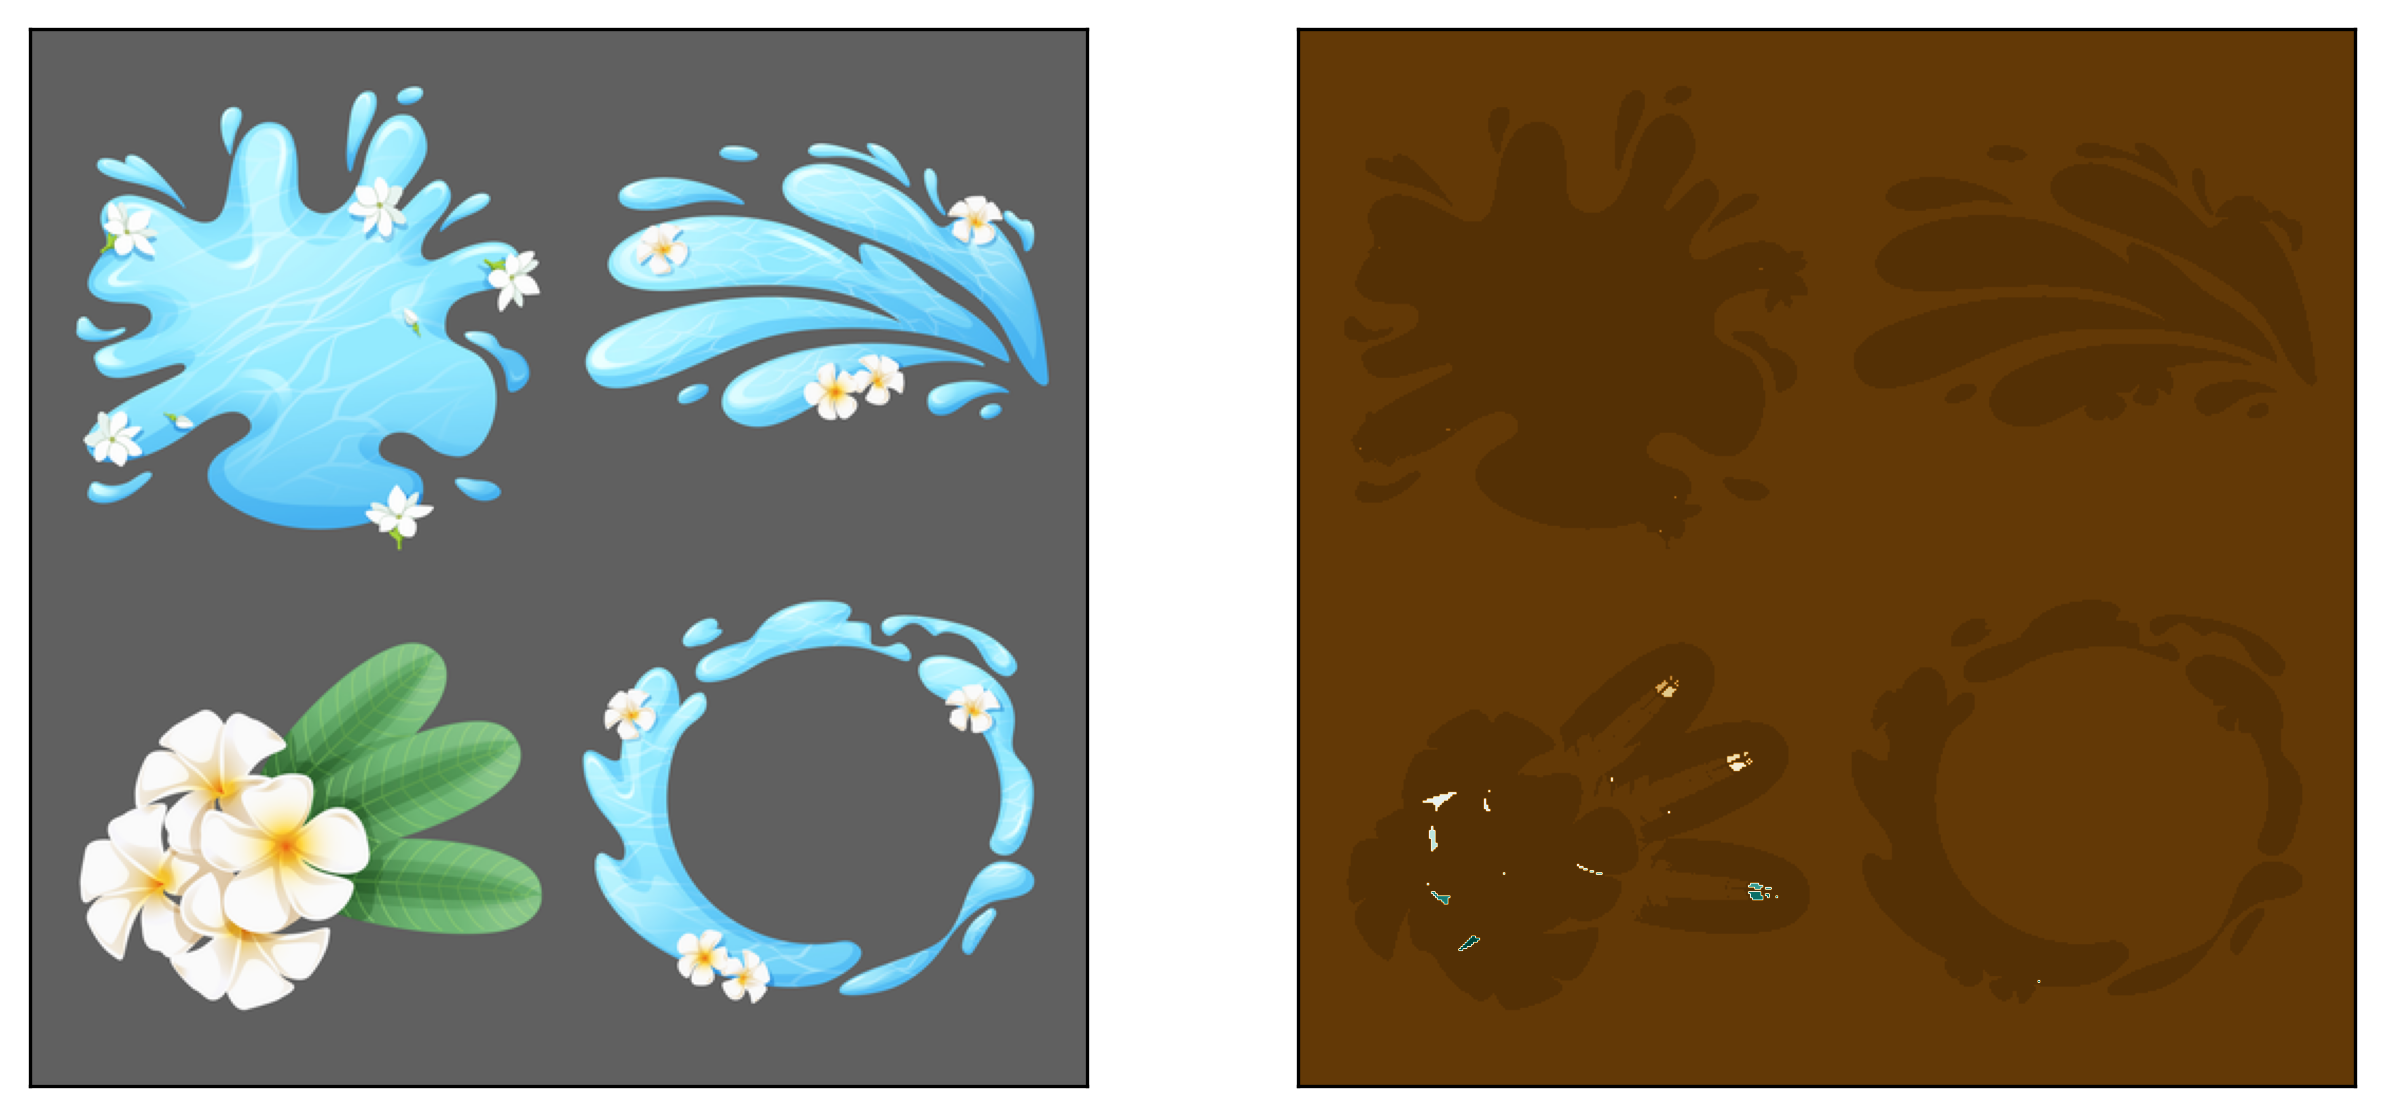

bus.jpg


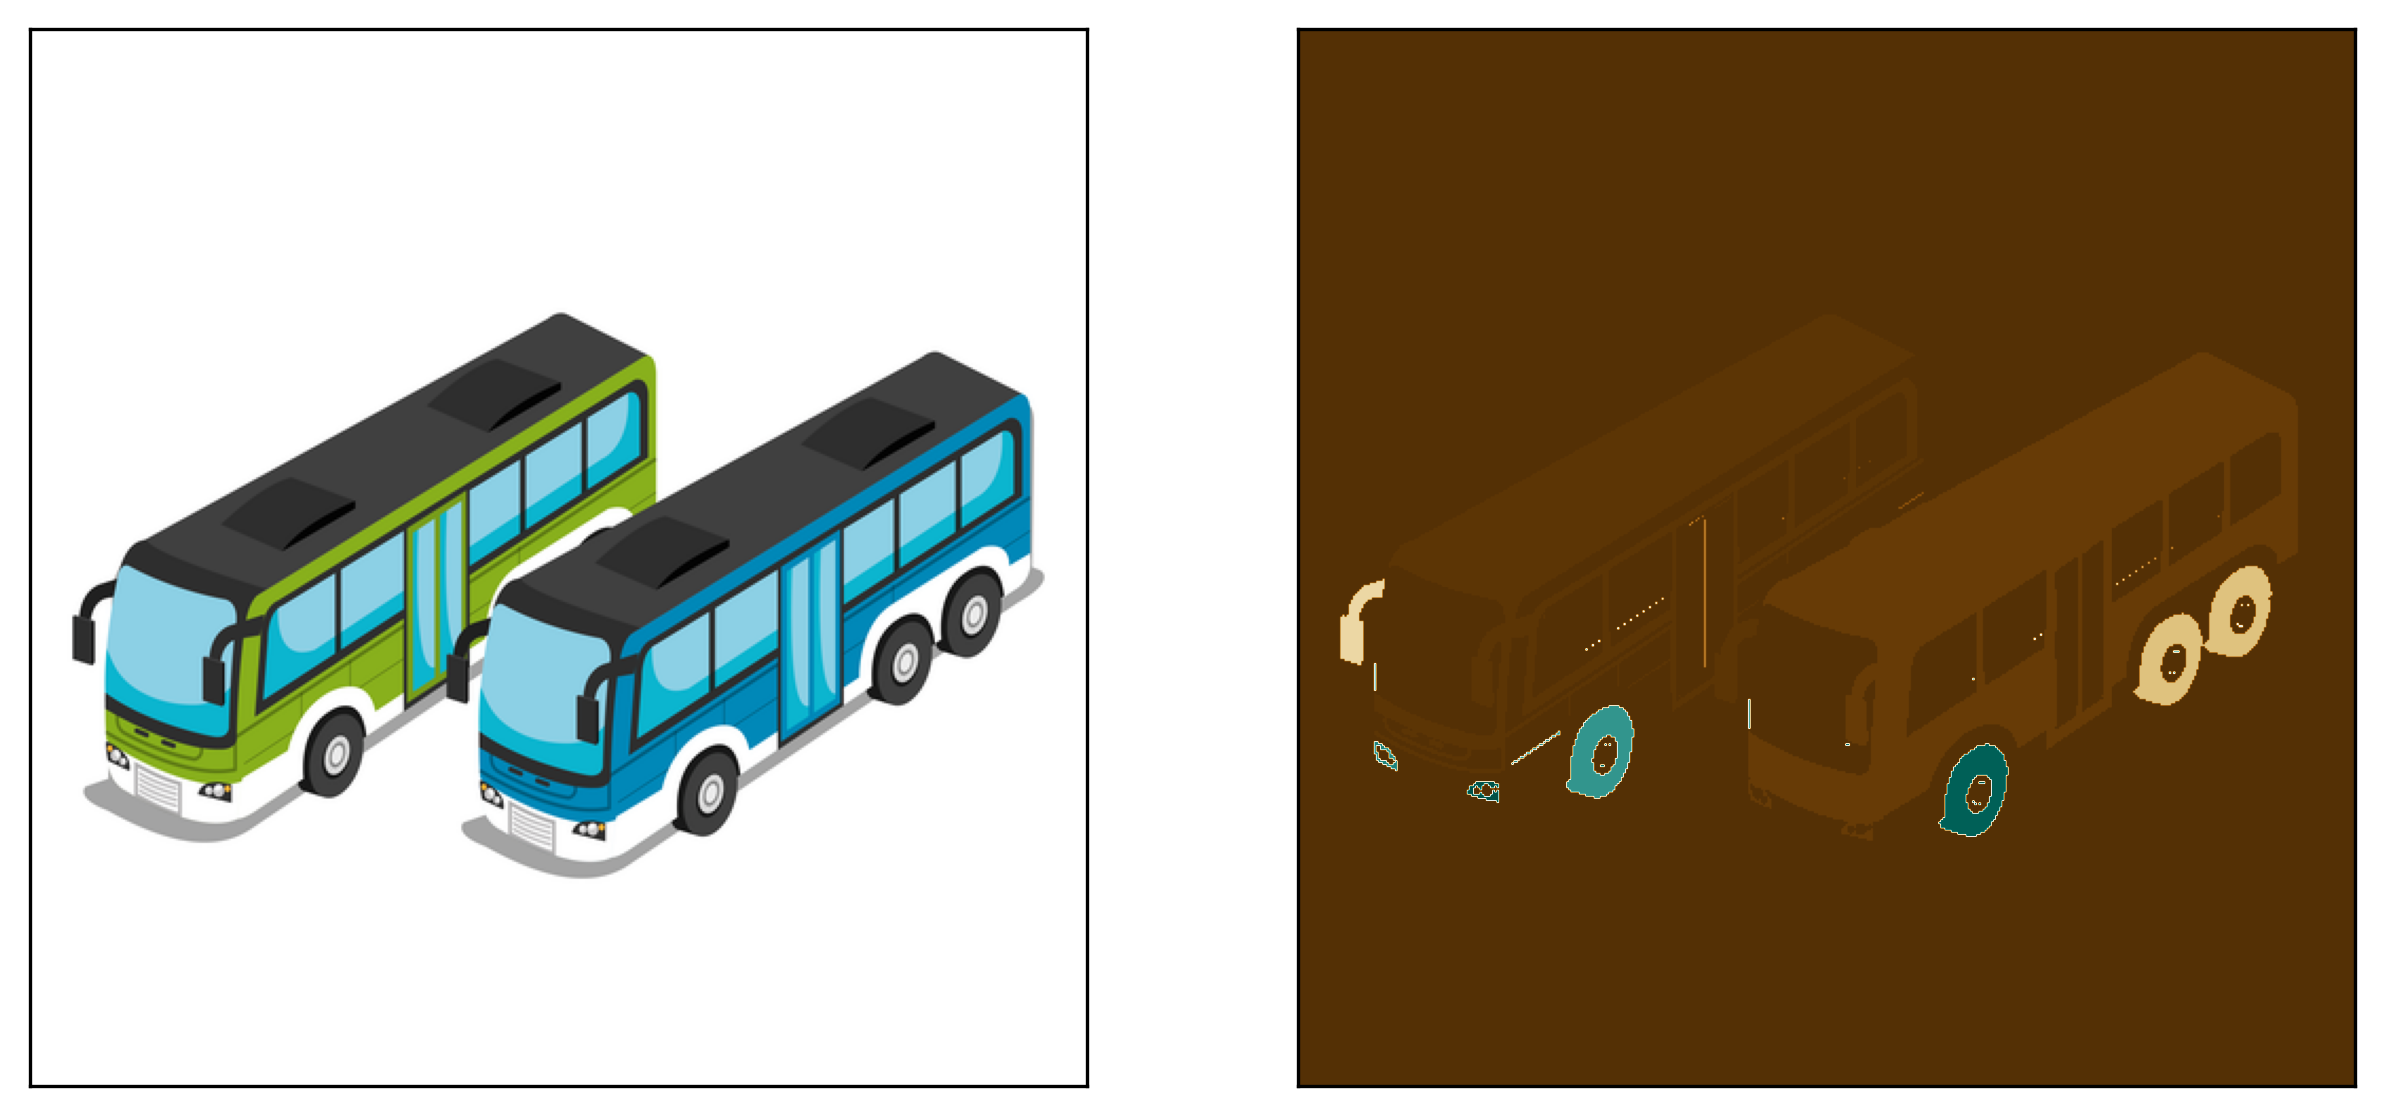

In [58]:
experiment()